In [1]:
import string
import spacy
spacy_nlp = spacy.load("en_core_web_sm")
import numpy as np
from spacy.lang.en.stop_words import STOP_WORDS
import utility_functions as utils
import importlib
import pandas as pd
from collections import defaultdict
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from transformers import pipeline
from tqdm import tqdm
import seaborn as sns

importlib.reload(utils)

custom_stop_words = list(STOP_WORDS)  # Existing stop words
custom_stop_words.extend(["ll", "ve", "'em", "em", "ho", "fo", "ah", "de"])  # Tokens which doesn't really make sense to hav`e them.

/Users/borosabel/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
topics0 = df[df['Topic Model Index'] == 0]['Topic Model'].iloc[0]
topics1 = df[df['Topic Model Index'] == 1]['Topic Model'].iloc[0]

In [2]:
df = pd.read_excel('/Users/borosabel/Documents/Uni/Thesis/PopMIR/Data/Excel/baseline_w_topics_w_entity.xlsx', engine='openpyxl')
_df = pd.read_excel('/Users/borosabel/Documents/Uni/Thesis/PopMIR/Data/Excel/baseline_data.xlsx', engine='openpyxl')

In [3]:
df['Lyrics'] = _df['Lyrics'].apply(utils.cleanup_entity_rec)

In [4]:
# Initialize the NER pipeline
ner_pipeline = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english", aggregation_strategy="simple")

def extract_entities(text):
    entities = ner_pipeline(text)
    return [{'entity': entity['word'], 'type': entity['entity_group'], 'score': entity['score']} for entity in entities]

tqdm.pandas(desc="Extracting entities")
df['Named_Entities'] = df['Lyrics'].progress_apply(extract_entities)

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Extracting entities: 100%|██████████| 1360/1360 [24:41<00:00,  1.09s/it] 


In [7]:
df.to_pickle('df_w_entity.pkl')

In [8]:
with open('corpus_entity.txt', 'w', encoding='utf-8') as file:
    for lyrics in df['Lyrics']:
        if pd.notna(lyrics):
            file.write(lyrics + '\n')

In [9]:
df_east = df[df['Coast'] == 'east_coast']
df_west = df[df['Coast'] == 'west_coast']

df_east_1 = df_east[df_east['Topic Model Index'] == 0]
df_east_2 = df_east[df_east['Topic Model Index'] == 1]
# df_east_3 = df_east[df_east['Topic Model Index'] == 2]
# df_east_4 = df_east[df_east['Topic Model Index'] == 3]

df_west_1 = df_west[df_west['Topic Model Index'] == 0]
df_west_2 = df_west[df_west['Topic Model Index'] == 1]
# df_west_3 = df_west[df_west['Topic Model Index'] == 2]
# df_west_4 = df_west[df_west['Topic Model Index'] == 3]

In [10]:
def populate_entities_by_type(df):
    entities_by_type = defaultdict(list)
    entity_indices = defaultdict(list)

    for index, entities in enumerate(df['Named_Entities']):
        if isinstance(entities, list):
            for entity in entities:
                if entity['score'] > 0.7:
                    entities_by_type[entity['type']].append(entity['entity'])
                    entity_indices[entity['entity']].append(index)

    return entities_by_type, entity_indices

def find_entries_containing_entities(df, entity_indices, search_entities):
    # Collect indices of rows that contain the search entities
    matching_indices = set()
    for entity in search_entities:
        if entity in entity_indices:
            matching_indices.update(entity_indices[entity])

    # Convert the set of matching indices to a list
    matching_indices = list(matching_indices)

    # Create a subset of the DataFrame with the matching rows
    subset_df = df.loc[matching_indices]

    return subset_df

In [11]:
entities_by_type_east, entity_indices_east = populate_entities_by_type(df_east)
entities_by_type_east_1, entity_indices_east_1 = populate_entities_by_type(df_east_1)
entities_by_type_east_2, entity_indices_east_2 = populate_entities_by_type(df_east_2)
# entities_by_type_east_3 = populate_entities_by_type(df_east_3)
# entities_by_type_east_4 = populate_entities_by_type(df_east_4)

entities_by_type_west, entity_indices_west = populate_entities_by_type(df_west)
entities_by_type_west_1, entity_indices_west_1 = populate_entities_by_type(df_west_1)
entities_by_type_west_2, entity_indices_west_2 = populate_entities_by_type(df_west_2)
# entities_by_type_west_3 = populate_entities_by_type(df_west_3)
# entities_by_type_west_4 = populate_entities_by_type(df_west_4)

In [11]:
def most_common_entities_by_type(entities_by_type):
    most_common_by_type = {}
    for entity_type, entities in entities_by_type.items():
        entity_counter = Counter(entities)
        most_common_by_type[entity_type] = entity_counter.most_common(20)
    return most_common_by_type

def print_most_common_entities(most_common_by_type, label):
    print(f"Most common entities for {label}:")
    for entity_type, common_entities in most_common_by_type.items():
        print(f"Top 10 common entities for type {entity_type}:")
        for entity, count in common_entities:
            print(f"{entity}: {count}")
    print()

most_common_by_type_east = most_common_entities_by_type(entities_by_type_east)
most_common_by_type_east_1 = most_common_entities_by_type(entities_by_type_east_1)
most_common_by_type_east_2 = most_common_entities_by_type(entities_by_type_east_2)
# most_common_by_type_east_3 = most_common_entities_by_type(entities_by_type_east_3)
# most_common_by_type_east_4 = most_common_entities_by_type(entities_by_type_east_4)

most_common_by_type_west = most_common_entities_by_type(entities_by_type_west)
most_common_by_type_west_1 = most_common_entities_by_type(entities_by_type_west_1)
most_common_by_type_west_2 = most_common_entities_by_type(entities_by_type_west_2)
# most_common_by_type_west_3 = most_common_entities_by_type(entities_by_type_west_3)
# most_common_by_type_west_4 = most_common_entities_by_type(entities_by_type_west_4)

In [12]:
print_most_common_entities(most_common_by_type_east, 'East Coast')
print_most_common_entities(most_common_by_type_east_1, f'East Coast, Topic Model {topics0}')
print_most_common_entities(most_common_by_type_east_2, f'East Coast, Topic Model {topics1}')
# print_most_common_entities(most_common_by_type_east_3, f'East Coast, Topic Model {topics2}')
# print_most_common_entities(most_common_by_type_east_4, f'East Coast, Topic Model {topics3}')

print_most_common_entities(most_common_by_type_west, 'West Coast')
print_most_common_entities(most_common_by_type_west_1, f'West Coast, Topic Model {topics0}')
print_most_common_entities(most_common_by_type_west_2, f'West Coast, Topic Model {topics1}')
# print_most_common_entities(most_common_by_type_west_3, f'West Coast, Topic Model {topics2}')
# print_most_common_entities(most_common_by_type_west_4, f'West Coast, Topic Model {topics3}')

Most common entities for East Coast:
Top 10 common entities for type PER:
God: 124
Jay: 43
Jack: 20
Joe: 17
Jimmy: 17
Mary: 17
Muhammad: 17
D: 16
Mike: 15
Smith: 14
Chuck: 13
Mike D: 13
Cool J: 13
Po: 13
Shortie: 13
Prince Paul: 12
Rakim: 11
Ma: 10
P: 10
Eric B: 10
Top 10 common entities for type MISC:
Black: 47
G: 15
R & B: 12
Afro: 11
White: 9
A: 8
French: 7
De La: 7
Wu - Tang: 6
Adidas: 6
Jamaican: 5
Lexus: 5
Asiatic: 5
Strike: 5
Luden: 5
African: 4
L: 4
AIDS: 4
R: 4
Swiss: 4
Top 10 common entities for type LOC:
New York: 49
California: 38
Brooklyn: 28
Motherland: 16
Queens: 16
Harlem: 11
Manhattan: 10
York: 9
Hollywood: 9
America: 8
Earth: 8
South: 7
Queensbridge: 7
Jersey: 6
Island: 6
Paris: 5
Los Angeles: 5
North: 5
Vegas: 5
Chicago: 5
Top 10 common entities for type ORG:
M: 24
D: 20
C: 18
G: 14
L: 12
De La Soul: 11
I: 10
R: 10
WRMS: 10
Public Enemy: 9
Tribe: 8
LL: 8
Wu - Tang Clan: 8
Tribe Called Quest: 7
B: 6
Adidas: 6
MAC: 6
Phillies: 6
QBC: 6
Quest: 5

Most common entities fo

In [114]:
def extract_contexts(df, entity_indices, search_tearm, window_size=5):
    contexts = defaultdict(list)

    if search_tearm in entity_indices:
        for index in entity_indices[search_tearm]:
            row_text = df.iloc[index]['Named_Entities']
            if isinstance(row_text, list):
                for entity_data in row_text:
                    if entity_data['entity'] == search_tearm and entity_data['score'] > 0.7:
                        contexts[search_tearm].append({
                            'context': extract_window(df.iloc[index]['Lyrics'], entity, window_size),
                            'row_index': index
                        })

    return contexts

def extract_window(text, entity, window_size):
    # Split text into words
    words = text.split()
    # Find the positions of the entity in the text
    positions = [i for i, word in enumerate(words) if entity.lower() in word.lower()]
    windows = []
    for pos in positions:
        start = max(0, pos - window_size)
        end = min(len(words), pos + window_size + 1)
        windows.append(' '.join(words[start:end]))

    return windows

In [122]:
search_cities = ['God']

entries_with_cities = find_entries_containing_entities(df_east, entity_indices_east, search_cities)

In [124]:
entries_with_cities

,Artist,Album,Song,Coast,Release Year,Tempo1,Tempo2,Duration (s),Sample Rate (Hz),Path,Lyrics,Topic Model,Named_Entities,Topic Model Index
256,Nas,Illmatic,It Ain't Hard to Tell.mp3,east_coast,1994,90.909091,45.801527,202.106667,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,Uh Q. B. since 1933 To nine-six Check the shit...,"['nigga', 'shit', 'ride', 'dick', 'bitch', 'di...","[{'entity': 'Escobar', 'type': 'PER', 'score':...",1
259,Nas,Illmatic,The World Is Yours.mp3,east_coast,1994,86.956522,43.795620,290.573333,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,"Motherfucking Dre, whassup my nigga? Sup Nas? ...","['nigga', 'shit', 'ride', 'dick', 'bitch', 'di...","[{'entity': 'Dr', 'type': 'PER', 'score': 0.81...",1
132,Run-DMC,Down With The King,To The Maker.mp3,east_coast,1993,171.428571,86.956522,24.800000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,"Linden Boulevard represent, represent Tribe Ca...","['rhyme', 'cuz', 'soul', 'rhythm', 'stage', 'l...","[{'entity': 'Linden Boulevard', 'type': 'ORG',...",0
261,Nas,Illmatic,Halftime.mp3,east_coast,1994,92.307692,45.801527,260.800000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,"Street's disciple, my raps are trifle I shoot ...","['rhyme', 'cuz', 'soul', 'rhythm', 'stage', 'l...","[{'entity': 'Mr', 'type': 'PER', 'score': 0.86...",0
637,Gang Starr,No More Mr. Nice Guy,Gang Starr - Gotch U.mp3,east_coast,1989,117.647059,58.823529,189.323917,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,"It's a Hell Up in Harlem, fuckit, another day ...","['rhyme', 'cuz', 'soul', 'rhythm', 'stage', 'l...","[{'entity': 'Harlem', 'type': 'LOC', 'score': ...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,Nas,It Was Written,Street Dreams.mp3,east_coast,1996,90.909091,45.454545,279.933333,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,"Yo, release what's in me Besides the Henny, it...","['nigga', 'shit', 'ride', 'dick', 'bitch', 'di...","[{'entity': 'He', 'type': 'PER', 'score': 0.45...",1
252,Nas,It Was Written,The Set Up.mp3,east_coast,1996,96.774194,48.000000,241.640000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,Fresh out the motherfuckin' pack For niggas do...,"['nigga', 'shit', 'ride', 'dick', 'bitch', 'di...","[{'entity': 'NYC', 'type': 'ORG', 'score': 0.7...",1
253,Nas,It Was Written,If I Ruled the World (Imagine That).mp3,east_coast,1996,93.750000,46.875000,282.373333,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,"They never realized how real Nas is, so decisi...","['nigga', 'shit', 'ride', 'dick', 'bitch', 'di...","[{'entity': 'Nas', 'type': 'PER', 'score': 0.8...",1
638,Gang Starr,No More Mr. Nice Guy,Gang Starr - 2 Step Ahead.mp3,east_coast,1989,117.647059,59.405941,230.446458,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,"One, one two Check me out right here yo Yo, th...","['nigga', 'shit', 'ride', 'dick', 'bitch', 'di...","[{'entity': 'P', 'type': 'PER', 'score': 0.936...",1


In [125]:
# context_word = 'California'
# contexts = extract_contexts(df_east_2, entity_indices_east_2, context_word)
# 
# # Print or inspect the contexts
# for entity, context_list in contexts.items():
#     print(f"Contexts for {entity}:")
#     for context in context_list:
#         print(f"Row Index: {context['row_index']}, Context: {context['context']}")

In [137]:
def plot_top_person_entities(most_common_east, most_common_west):
    # Extract top person entities and their counts
    top_persons_east = {entity: count for entity, count in most_common_east.get('PER', [])[:1]}
    top_persons_west = {entity: count for entity, count in most_common_west.get('PER', [])[:1]}

    # Calculate total counts for each coast
    total_east = sum(count for entity, count in most_common_east.get('PER', []))
    total_west = sum(count for entity, count in most_common_west.get('PER', []))

    # Combine the data into a DataFrame for plotting
    data = []
    for entity, count in top_persons_east.items():
        percentage = (count / total_east) * 100 if total_east > 0 else 0
        data.append({'Entity': entity, 'Count': count, 'Percentage': percentage, 'Coast': 'East'})
    for entity, count in top_persons_west.items():
        percentage = (count / total_west) * 100 if total_west > 0 else 0
        data.append({'Entity': entity, 'Count': count, 'Percentage': percentage, 'Coast': 'West'})

    df_plot = pd.DataFrame(data)

    # Plot the data
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='Entity', y='Count', hue='Coast', data=df_plot, palette={'East': 'blue', 'West': 'red'})
    plt.title('Most Popular Person Entity in East Coast and West Coast')
    plt.xticks(rotation=45)

    # Add count and percentage labels on top of the bars
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'{int(height)}',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=10)

    plt.show()

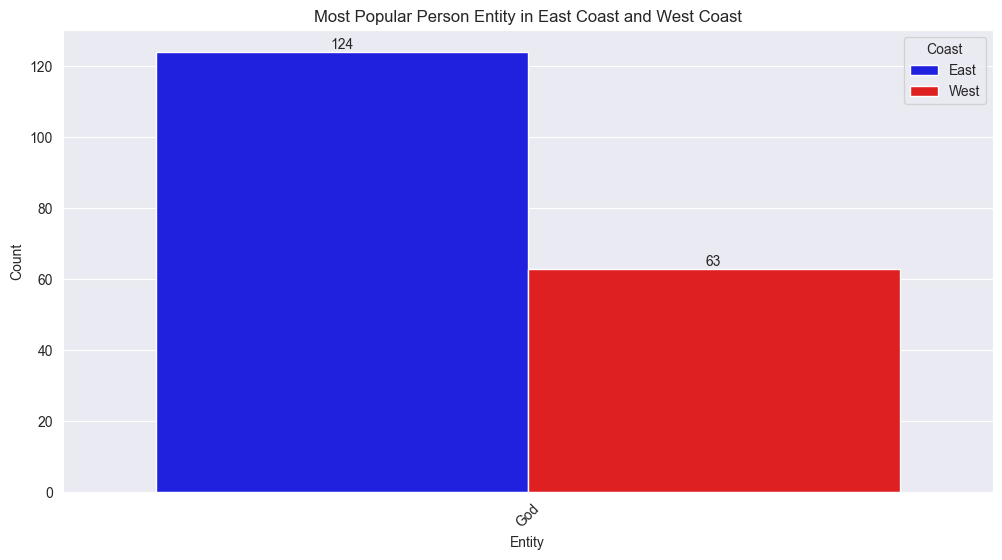

In [138]:
plot_top_person_entities(most_common_by_type_east, most_common_by_type_west)

In [6]:
def plot_top_location_entities(most_common_east, most_common_west):
    # Extract top person entities and their counts
    top_persons_east = {entity: count for entity, count in most_common_east.get('LOC', [])[:10]}
    top_persons_west = {entity: count for entity, count in most_common_west.get('LOC', [])[:10]}

    # Calculate total counts for each coast
    total_east = sum(count for entity, count in most_common_east.get('LOC', []))
    total_west = sum(count for entity, count in most_common_west.get('LOC', []))

    # Combine the data into a DataFrame for plotting
    data = []
    for entity, count in top_persons_east.items():
        percentage = (count / total_east) * 100 if total_east > 0 else 0
        data.append({'Entity': entity, 'Count': count, 'Percentage': percentage, 'Coast': 'East'})
    for entity, count in top_persons_west.items():
        percentage = (count / total_west) * 100 if total_west > 0 else 0
        data.append({'Entity': entity, 'Count': count, 'Percentage': percentage, 'Coast': 'West'})

    df_plot = pd.DataFrame(data)

    # Plot the data
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='Entity', y='Count', hue='Coast', data=df_plot, palette={'East': 'blue', 'West': 'red'})
    plt.title('Most Popular Person Entity in East Coast and West Coast')
    plt.xticks(rotation=45)

    # Add count and percentage labels on top of the bars
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'{int(height)}',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=10)

    plt.show()

In [7]:
plot_top_location_entities(most_common_by_type_east, most_common_by_type_west)

NameError: name 'most_common_by_type_east' is not defined

In [16]:
def populate_locations_by_coast(df):
    locations_by_coast = defaultdict(list)

    for index, row in df.iterrows():
        if isinstance(row['Named_Entities'], list):
            for entity in row['Named_Entities']:
                if entity['type'] == 'LOC' and entity['score'] > 0.5:  # Assuming 'LOC' is the type for locations
                    locations_by_coast[row['Coast']].append(entity['entity'])

    return locations_by_coast

In [17]:
locations_by_coast = populate_locations_by_coast(df)

# Convert the dictionary to a DataFrame for easier handling
location_data = []
for coast, locations in locations_by_coast.items():
    for location in locations:
            location_data.append({'Coast': coast, 'Location': location})

location_df = pd.DataFrame(location_data)

In [18]:
location_df

,Coast,Location
0,east_coast,New York
1,east_coast,California
2,east_coast,New York
3,east_coast,Canada
4,east_coast,N
...,...,...
1600,west_coast,Phil
1601,west_coast,Phil
1602,west_coast,Compton
1603,west_coast,L


In [20]:
# Save the DataFrame to an Excel file
location_df.to_excel('locations_by_coast.xlsx', index=False)